# Maximum Likelihood RUN 1

### The raw PyBDSF catalogue, optical, NIR catalogues and, the MASTER LIST are used

---

In [1]:
# Load in all the required functions

from socket import gethostname

if gethostname() == 'colonsay':
    PATH_START = '/disk1/rohitk/ELN1_project/'

elif gethostname() == 'rohitk-elitebook':
    PATH_START = '/home/rohitk/Documents/PhD/Year1/ELN1_project/'

# Path start for Max_L analysis
# PATH_START = PATH_START + "OCT17_ELAIS_im/maxl_test/"
    
#################################################
# Add the path of useful functions at the start

import sys

# Import some important functions
#sys.path.append(PATH_START+'basic_functions')

import importlib

# Import coordinate converstion functions
from useful_functions import field_filter, get_overlap_sources, latest_dir, logspace_bins, return_hist_par
#from overlapping_area import (isinpan, isinukidss, isinSWIRE, isinSERVS)
from plot_func import rc_def, make_fig
rc_def()

# For reading in MOC files and filtering catalogues
from moc_util import coords_to_hpidx, inMoc
##################################################

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import time

from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky


# Multiprocessin method of doing the ML analysis
import multiprocessing as mp
from functools import partial

import pickle

ts = time.time()
# %pylab inline
import matplotlib as mpl
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["axes.labelsize"] = 18

import os
from time import strftime
import glob

# For MOC creation files
import pymoc.io.fits
import healpy as hp
import pymoc.util.catalog
from mocpy import MOC, WCS

In [2]:
# Import ML functions from mlrun1
import mlrun1_bootes
importlib.reload(mlrun1_bootes)


from mlrun1_bootes import (varstat, survey_area, get_sigma_all_old, get_fr_old, get_bin_list, get_n_m, get_q_m, 
                    generate_rand_pos_servs, get_Q0, compute_Fr, get_nm_interp,
                    get_qm_interp, get_lr)

from mlrun1_bootes import (generate_rand_pos_bootes, get_n_m_kde, get_q_m_kde, estimate_q_m_kde, get_sigma_all, gen_binc_binl, gen_rand_cat_inMOC)
# from mlrun1 import survey_area

## Contents

In [3]:
help_opt = pickle.load(open('help_opt_nqm.pkl','rb'))
help_ir = pickle.load(open('help_ir_nqm.pkl','rb'))

### PanSTARRS and UKIDSS survey areas <a class="anchor" id="survey-area"></a>

In [4]:
# Survey area definitions - used for generated random catalogue and select the relevant PanSTARRS sources

# PanSTARRS "rectangle box" definition
p_ra_down = 160.2
p_dec_down = 57.2
p_ra_up = 164.1
p_dec_up = 58.5

# UKIDSS survey area

# Get the area of the rectangle used for n(m)
# Get the PanSTARRS area in arcsec
pan_area = survey_area(p_ra_up, p_dec_up, p_ra_down, p_dec_down)
print(pan_area)

34964523.7041


## Load Catalogues <a class="anchor" id="load-catalogues"></a>

In [5]:
# Definition of the paths

# PATH_MASTER_LIST = "/disk3/rohitk/ELAIS_opt_swarped/dual_analysis/combine/MASTER_catalogue/MASTER_opt_spitzer_merged_forML.fits"
# PATH_PYBDSF_RAW = "/disk1/rohitk/ELN1_project/EN1_comb10/image_full_ampphase_di_m.NS.int.restored.pybdsm.srl.fits"


#PATH_PYBDSF_RAW = "data/image_full_ampphase_di_m.NS_shift.int.facetRestored-scaled.pybdsm.srl_foverlap.fits"
PATH_PYBDSF_RAW = 'data/edited_cats/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat_foverlap.fits'
#PATH_MASTER_LIST = "data/EN1_MASTER_opt_spitzer_merged_forML.fits"
PATH_MASTER_LIST = "data/edited_cats/optical/LH_MASTER_opt_spitzer_merged_forLGZ.fits"
PATH_HELP_CAT = '../../../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits'

In [6]:
# Get the type of catalogue (srl) or (gaul)
"""if PATH_PYBDSF_RAW.split("/")[-1][-8:-5] == "srl":
    cat_type = "_srl"
    id_type = "Source_id"  # Column name to choose - NOT USED
elif PATH_PYBDSF_RAW.split("/")[-1][-9:-5] == "gaul":
    cat_type = "_gaul"
    id_type = "Gaus_id"
""";

cat_type = "_srl"    
print(cat_type)

_srl


In [7]:
# Read in Master List - This contains all of the magnitudes for the 20 filters
master = Table.read(PATH_MASTER_LIST, hdu=2)

# Read in Final Catalogue - LOFAR DATA
deepfull = Table.read(PATH_PYBDSF_RAW)

# Read in the HELP Lockman masterlist for LR comparison
helpcat = Table.read(PATH_HELP_CAT)

In [8]:
# Load in the MOCs
PATH_MOC_r = "data/edited_cats/optical/mocs/LH_r_moc_order_18_MOC_with_add.fits"
PATH_MOC_se2 = "data/edited_cats/optical/mocs/LH_se2_moc_order_18_MOC.fits"
PATH_MOC_sw2 = "data/edited_cats/optical/mocs/LH_sw2_moc_order_18_MOC.fits"

moc_r = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_r, PATH_MOC_r)

moc_se2 = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_se2, PATH_MOC_se2)

moc_sw2 = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_sw2, PATH_MOC_sw2)

print("Area of r-MOC: {0} sq. deg.".format(moc_r.area_sq_deg))
print("Area of se2-MOC: {0} sq. deg.".format(moc_se2.area_sq_deg))
print("Area of sw2-MOC: {0} sq. deg.".format(moc_sw2.area_sq_deg))

moc_sw_only = moc_sw2 - moc_se2
print("Area of sw_only-MOC: {0} sq. deg.".format(moc_sw_only.area_sq_deg))

Area of r-MOC: 13.321917803932173 sq. deg.
Area of se2-MOC: 5.574102257180664 sq. deg.
Area of sw2-MOC: 10.949807996199757 sq. deg.
Area of sw_only-MOC: 5.375745409478163 sq. deg.


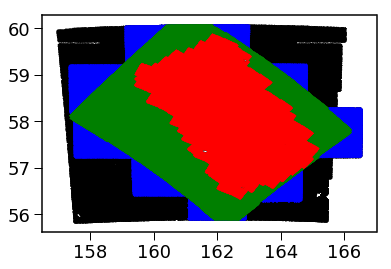

In [9]:
ra = master['ALPHA_J2000'].quantity.value
dec = master['DELTA_J2000'].quantity.value


x = master['ALPHA_J2000']
y = master['DELTA_J2000']
plt.scatter(x,y,s=0.1,c='black')

mask = inMoc(ra,dec,moc_r)
x = master['ALPHA_J2000'][mask]
y = master['DELTA_J2000'][mask]
plt.scatter(x,y,s=0.1,c='blue')

mask = inMoc(ra,dec,moc_sw2)
x = master['ALPHA_J2000'][mask]
y = master['DELTA_J2000'][mask]
plt.scatter(x,y,s=0.1,c='green')

mask = inMoc(ra,dec,moc_se2)
x = master['ALPHA_J2000'][mask]
y = master['DELTA_J2000'][mask]
plt.scatter(x,y,s=0.1,c='red')
plt.show()

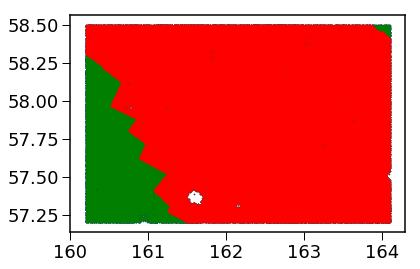

In [10]:
master_rect_ind = ((field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])))

ra = master['ALPHA_J2000'].quantity.value
dec = master['DELTA_J2000'].quantity.value

x = master['ALPHA_J2000'][master_rect_ind]
y = master['DELTA_J2000'][master_rect_ind]
plt.scatter(x,y,s=0.1,c='black')

mask = inMoc(ra,dec,moc_r)
x = master['ALPHA_J2000'][mask&master_rect_ind]
y = master['DELTA_J2000'][mask&master_rect_ind]
plt.scatter(x,y,s=0.1,c='blue')

mask = inMoc(ra,dec,moc_sw2)
x = master['ALPHA_J2000'][mask&master_rect_ind]
y = master['DELTA_J2000'][mask&master_rect_ind]
plt.scatter(x,y,s=0.1,c='green')

mask = inMoc(ra,dec,moc_se2)
x = master['ALPHA_J2000'][mask&master_rect_ind]
y = master['DELTA_J2000'][mask&master_rect_ind]
plt.scatter(x,y,s=0.1,c='red')
plt.show()

## Filter LOFAR Catalogue and MASTER catalogue <a class="anchor" id="filter-lofar"></a>

In [92]:
# Filter the LOFAR catalogue to the overlapping area and S sources

maj_cut = 10.  # Major axis size cut (in arcsec) for radio catalogue

# Select the sources that will be used for LR analysis
workflow_iter = True

if workflow_iter:
    #workflow_latest_dir = latest_dir("workflow_iter_*")
    #indx_forlr = pickle.load(open(workflow_latest_dir + "/sources_to_send_to_lr.pckl", "rb"))
    indx_forlr = pickle.load(open("workflow_iter_1/sources_to_send_to_lr.pckl", "rb"))
    
    print("***** USING LOFAR SOURCES FROM WORKFLOW OUTPUT ****")
    print("No. of radio sources used for calibration now: {0}".format(np.sum(indx_forlr)))
    


else:
    # Otherwise, compute the sources in the different MOCs
    # in_ps = inMoc(deepfull["RA"], deepfull["DEC"], moc_i)
    # in_K = inMoc(deepfull["RA"], deepfull["DEC"], moc_K)
    # in_sw2 = inMoc(deepfull["RA"], deepfull["DEC"], moc_sw2)

    # Filter sources based on ovelrlap and S_Code and Major axis size
    # indx_forlr = (((in_ps) & (in_K) & (in_sw2)) & (deepfull["S_Code"].lower() == "s") & (deepfull["Maj"] * 3600. <= maj_cut))
    
    indx_forlr = ((deepfull["S_Code"] == "S") & (deepfull["Maj"] * 3600. <= maj_cut) & (deepfull["FLAG_OVERLAP"] == 3))
    print("Number of radio sources with S, Maj < {0}'' and overlapping: {1}".format(maj_cut, np.sum(indx_forlr)))
        
# Get the bool array of sources within the rectangular area for area calculations
lofar_rect = field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, deepfull["RA"], deepfull["DEC"])

# Now index and get the entire catalogue
final = deepfull[indx_forlr]


***** USING LOFAR SOURCES FROM WORKFLOW OUTPUT ****
No. of radio sources used for calibration now: 26948


## PanSTARRS i-band ML matching <a class="anchor" id="pani_analysis"></a>

In [93]:
filt = "r"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

snr_th = 3.
snr_band = master[sflux_col] / master[seflux_col]

# Any null values for sources
null_mag = -99

### n(m) PanSTARRS i-band <a class="anchor" id="comp-nm_i"></a>

$\textbf{Definition:}$ n(m) is the number of sources in the optical/NIR catalogue below a magnitude, m within an area of 1arcsec (i.e. divide by the area of the survey)

Sources used for analysis of n(m): 356878
Properties of n(m) in i-band: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.004099   0.000439   0.004733   559        5.4008545655e-77 0.010207   0         


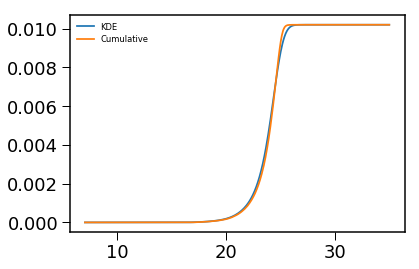

In [94]:
# Get the bin_list for computing n(m) for i band

# Find all the optical catalogue sources within the rectangle and those with non-99 magnitudes
master_rect_ind = ((field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])) &
                   (master[mag_col] != null_mag) & (snr_band >= snr_th))

print("Sources used for analysis of n(m): {0}".format(np.sum(master_rect_ind)))

# _, nm_be_i, nm_bc_i = return_hist_par(0.05, master[mag_col][master_rect_ind])

nm_be_i, nm_bc_i = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the i band
nm_i_old = get_n_m(master[mag_col][master_rect_ind], nm_be_i, pan_area)
nm_i = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_i, area=pan_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m) in i-band: ")
varstat(np.cumsum(nm_i))

# Compute sigma for each source
# print("Diff in PanSTARRS area: " + str(46390728.8503 - pan_area)+" arcsec**2")

fig = plt.figure()

plt.plot(nm_bc_i, np.cumsum(nm_i), label='KDE')
plt.plot(nm_bc_i, nm_i_old, label='Cumulative')
#plt.plot(nm_bc_i-0.025, np.log10(help_opt[0]), label='help')
#plt.ylim(-6,-1.6)
#plt.xlim(15,30)
plt.legend()

In [95]:
# Write the n(m) distribution to pckl file to compare with the other fields
# pickle.dump([nm_bc_i, nm_i, nm_i_old], open("EN1_nm_i_2asec_apcorr.pckl", "wb"))

## q(m) PanSTARRS i-band <a class="anchor" id="comp-qm_i"></a>

$\textbf{Definition:}$ q(m) is the apriori probability that the radio source has a counterpart brighter than magnitude m.
* Depends on real(m) and Q$_0$

In [96]:
lofar_co = SkyCoord(final['RA'], final['DEC'], unit=(u.deg,u.deg),
                    frame='icrs')

# Define i-only sources as sources with a SNR > 3 (or 5) in the i-band

i_only_bool = ((master[sflux_col] / master[seflux_col] >= snr_th) &
               (master["flag_clean"] == 1) & (master[mag_col] != null_mag))
print(np.sum(i_only_bool))

# overlap_flag = (master["FLAG_OVERLAP"] == 7) | (master["flag_overlap"] == 1) | (master["flag_overlap"] == 3) | (master["flag_overlap"] == 5)

i_only_bool = ((snr_band >= snr_th) & (master[mag_col] != null_mag) & master["flag_clean"] == 1)

# i_only_bool = ((master[mag_col] != null_mag) & (snr_band >= snr_th))
print(np.sum(i_only_bool))

pani_coords = SkyCoord(master['ALPHA_J2000'][i_only_bool], 
                       master['DELTA_J2000'][i_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of LOFAR and PanSTARRS sources used in analysis from now on: ")
print(len(lofar_co))
print(len(pani_coords))

1698151
1825178
No. of LOFAR and PanSTARRS sources used in analysis from now on: 
26948
1825178


Unique opt_ind:  42282
Unique LOFAR ind:  24321
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.463523   0.27376    0.463482   559        1.96738511427e-71 1.0        0         
None


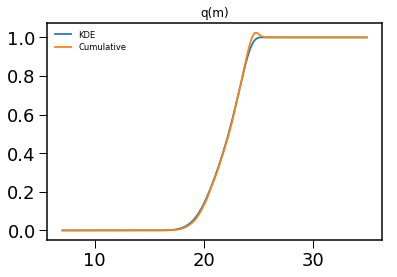

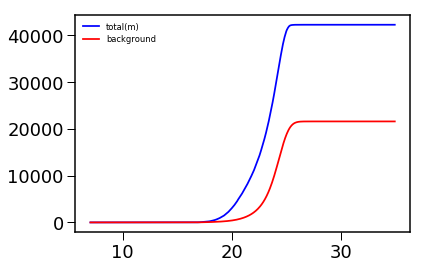

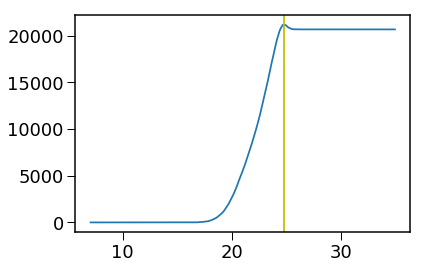

In [97]:
# Compute q(m)

RMAX = 5.

qm_i_old, tm_i, rm_i = get_q_m(lofar_co, pani_coords, RMAX, master[mag_col][i_only_bool], nm_be_i, pan_area, nm_i_old)

qm_i = estimate_q_m_kde(master[mag_col][i_only_bool], nm_bc_i, nm_i,
                        lofar_co, pani_coords, RMAX, bandwidth=0.5)

print(varstat(np.cumsum(qm_i)))

fig = plt.figure()
plt.plot(nm_bc_i, np.cumsum(qm_i), label='KDE')
plt.plot(nm_bc_i, qm_i_old, label='Cumulative')
plt.legend()
plt.title("q(m)")

fig = plt.figure()

plt.plot(nm_bc_i, tm_i, color='b', label='total(m)')
plt.plot(nm_bc_i, np.pi * RMAX**2 * np.cumsum(nm_i) * (len(lofar_co)), color='r', label='background')
plt.legend()

fig = plt.figure()
plt.plot(nm_bc_i, rm_i, label='real(m)')
plt.axvline(x=nm_bc_i[np.argmax(rm_i)], ymin=0, ymax=1, color='y')

#plt.yscale('log')


## For HELP
## q(m) PanSTARRS i-band <a class="anchor" id="comp-qm_i"></a>

$\textbf{Definition:}$ q(m) is the apriori probability that the radio source has a counterpart brighter than magnitude m.
* Depends on real(m) and Q$_0$

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Sources used for analysis of n(m): 451176
Properties of n(m) in i-band: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.004099   0.000439   0.004733   559        5.4008545655e-77 0.010207   0         


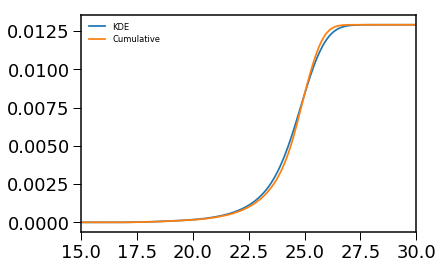

In [98]:
# Get the bin_list for computing n(m) for i band

# Find all the optical catalogue sources within the rectangle and those with non-99 magnitudes
helpcat_rect_ind = ((field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, helpcat["ra"], helpcat["dec"])) &
                   (~np.isnan(helpcat['f_ap_megacam_r'])) & (helpcat['f_ap_megacam_r']/helpcat['ferr_ap_megacam_r']>3))

print("Sources used for analysis of n(m): {0}".format(np.sum(helpcat_rect_ind)))

# _, nm_be_i, nm_bc_i = return_hist_par(0.05, helpcat[mag_col][helpcat_rect_ind])

nm_be_i, nm_bc_i = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the i band
nm_i_old_help = get_n_m(helpcat['m_ap_megacam_r'][helpcat_rect_ind], nm_be_i, pan_area)
nm_i_help = get_n_m_kde(helpcat['m_ap_megacam_r'][helpcat_rect_ind], nm_bc_i, area=pan_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m) in i-band: ")
varstat(np.cumsum(nm_i))

# Compute sigma for each source
# print("Diff in PanSTARRS area: " + str(46390728.8503 - pan_area)+" arcsec**2")

fig = plt.figure()

plt.plot(nm_bc_i, np.cumsum(nm_i_help), label='KDE')
plt.plot(nm_bc_i, nm_i_old_help, label='Cumulative')
#plt.plot(nm_bc_i-0.025, np.log10(help_opt[0]), label='help')
#plt.ylim(-6,-1.6)
plt.xlim(15,30)
plt.legend()

In [99]:
#same as above but for the HELP masterlist


# overlap_flag = (master["FLAG_OVERLAP"] == 7) | (master["flag_overlap"] == 1) | (master["flag_overlap"] == 3) | (master["flag_overlap"] == 5)

help_only_bool = (~np.isnan(helpcat['f_ap_megacam_r'])) & (helpcat['f_ap_megacam_r']/helpcat['ferr_ap_megacam_r']>3)

# i_only_bool = ((master[mag_col] != null_mag) & (snr_band >= snr_th))
print(np.sum(i_only_bool))

help_coords = SkyCoord(helpcat['ra'][help_only_bool], 
                       helpcat['dec'][help_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of LOFAR and PanSTARRS sources used in analysis from now on: ")
print(len(lofar_co))
print(len(help_coords))

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


1825178
No. of LOFAR and PanSTARRS sources used in analysis from now on: 
26948
2457842


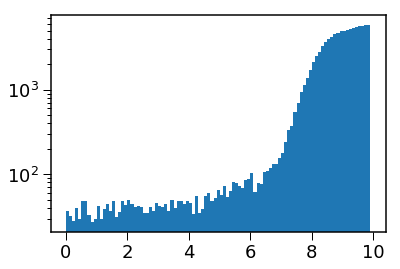

In [100]:
mask = ~np.isnan(helpcat['f_megacam_r'])
plt.hist(helpcat['f_megacam_r'][mask]/helpcat['ferr_megacam_r'][mask],bins=np.arange(0,10,0.1),log=True)
plt.show()  

In [101]:
len(master)

3041794

In [102]:
len(helpcat)

4366298

Unique opt_ind:  48578
Unique LOFAR ind:  24328
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.463523   0.27376    0.463482   559        1.96738511427e-71 1.0        0         
None


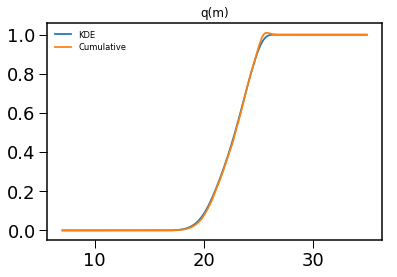

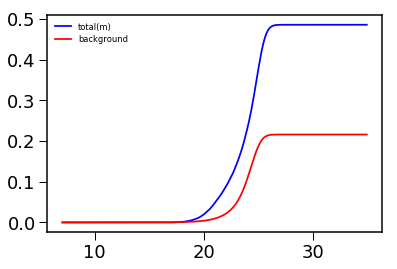

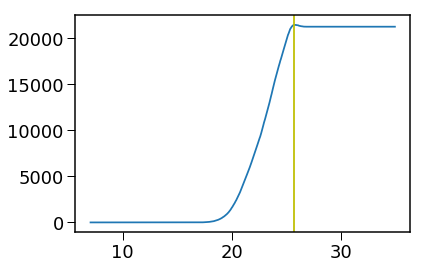

In [103]:
# Compute q(m)

RMAX = 5.

qm_i_old_help, tm_i_help, rm_i_help = get_q_m(lofar_co, help_coords, RMAX, helpcat['m_ap_megacam_r'][help_only_bool], nm_be_i, pan_area, nm_i_old_help)

qm_i_help = estimate_q_m_kde(helpcat['m_ap_megacam_r'][help_only_bool], nm_bc_i, nm_i_help,
                        lofar_co, help_coords, RMAX, bandwidth=0.5)

print(varstat(np.cumsum(qm_i)))

fig = plt.figure()
plt.plot(nm_bc_i, np.cumsum(qm_i_help), label='KDE')
plt.plot(nm_bc_i, qm_i_old_help, label='Cumulative')
plt.legend()
plt.title("q(m)")

fig = plt.figure()

plt.plot(nm_bc_i, tm_i_help/100000, color='b', label='total(m)')
plt.plot(nm_bc_i, (np.pi * RMAX**2 * np.cumsum(nm_i) * (len(lofar_co)))/100000, color='r', label='background')
plt.legend()

fig = plt.figure()
plt.plot(nm_bc_i, rm_i_help, label='real(m)')
plt.axvline(x=nm_bc_i[np.argmax(rm_i_help)], ymin=0, ymax=1, color='y')

#plt.yscale('log')



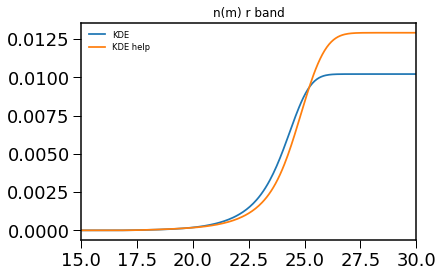

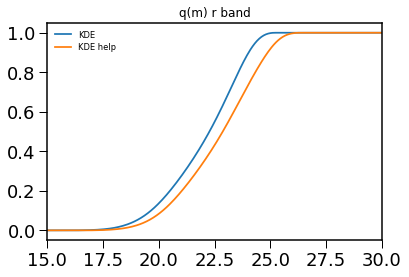

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


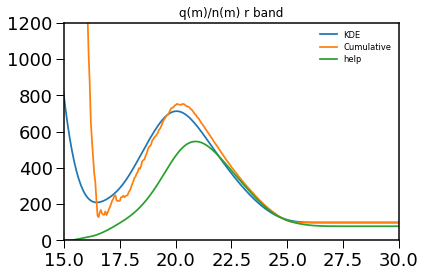

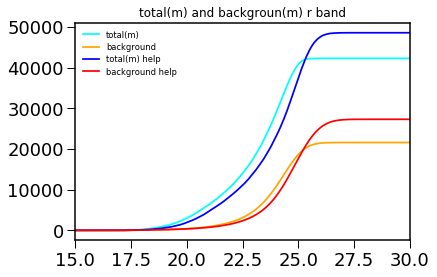

In [104]:
plt.plot(nm_bc_i, np.cumsum(nm_i), label='KDE')
#plt.plot(nm_bc_i, np.log10(nm_i_old), label='Cumulative')
plt.plot(nm_bc_i, np.cumsum(nm_i_help), label='KDE help')
#plt.plot(nm_bc_i, np.log10(nm_i_old_help), label='Cumulative help')
#plt.plot(nm_bc_i-0.025, np.log10(help_opt[0]), label='help')
#plt.ylim(-6,-1.6)
plt.xlim(15,30)
plt.title("n(m) r band")
plt.legend()
plt.show()

plt.plot(nm_bc_i, np.cumsum(qm_i), label='KDE')
#plt.plot(nm_bc_i, qm_i_old, label='Cumulative')
plt.plot(nm_bc_i, np.cumsum(qm_i_help), label='KDE help')
plt.legend()
plt.title("q(m) r band")
plt.xlim(15,30)
plt.show()

plt.plot(nm_bc_i, np.cumsum(qm_i)/np.cumsum(nm_i), label='KDE')
plt.plot(nm_bc_i, qm_i_old/nm_i_old, label='Cumulative')
plt.plot(nm_bc_i, np.cumsum(qm_i_help)/np.cumsum(nm_i_help), label='help')
plt.legend()
plt.title("q(m)/n(m) r band")
plt.xlim(15,30)
plt.ylim(0,1200)
plt.show()

plt.plot(nm_bc_i, tm_i, color='cyan', label='total(m)')
plt.plot(nm_bc_i, np.pi * RMAX**2 * np.cumsum(nm_i) * (len(lofar_co)), color='orange', label='background')
plt.plot(nm_bc_i, tm_i_help, color='b', label='total(m) help')
plt.plot(nm_bc_i, np.pi * RMAX**2 * np.cumsum(nm_i_help) * (len(lofar_co)), color='r', label='background help')
plt.title('total(m) and backgroun(m) r band')
plt.xlim(15,30)
plt.legend()

In [105]:
# Write the q(m) distribution to pckl file to compare with the other fields
# pickle.dump([nm_bc_i, qm_i, qm_i_old], open("EN1_qm_i_2asec_apcorr.pckl", "wb"))

### Compute Q$_0$ <a class="anchor" id="comp-q0_i"></a>

#### Firstly, redefine coordinates to include all the sources in the overlapping area

Timetaken: 7.287023067474365
Radius Blanks Random Blanks Q_0
1 9754 26051 0.6255805919158574
2 5920 23560 0.7487266553480476
3 4642 19999 0.767888394419721
4 3556 15850 0.7756466876971608
5 2627 11782 0.7770327618400951
6 1864 8264 0.7744433688286544
7 1274 5509 0.7687420584498094
8 844 3540 0.7615819209039548
9 546 2219 0.7539432176656151


Text(0, 0.5, '$Q_0$')

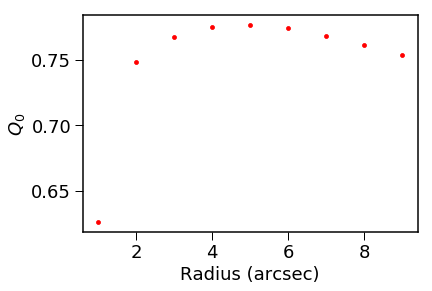

In [106]:
# Compute Q_0 for the i band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_li = []
l_no_m_i = []
r_no_m_i = []

rad = np.arange(1,10)

# Generate random coords
rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down, len(lofar_co))

for k in range(len(rad)):
    q0_i, nl_non_i, nr_non_i = get_Q0(lofar_co, pani_coords, rand_coords, float(rad[k]))
    q0_li.append(q0_i)
    l_no_m_i.append(nl_non_i)
    r_no_m_i.append(nr_non_i)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_li)):
    
    print(rad[aa], l_no_m_i[aa], r_no_m_i[aa], q0_li[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_li, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [107]:
# Estimate a mean Q_0 value for the i-band
mean_Q0_vals = []
mean_Q0_i = np.mean(q0_li[2:6])
print(mean_Q0_i)

print("Different Q0 averaging used!")
mean_Q0_i = np.max(q0_li)
mean_Q0_vals.append(mean_Q0_i)

print("Q_0 for r band: " + str(mean_Q0_i))

0.773752803196
Different Q0 averaging used!
Q_0 for r band: 0.77703276184


## Q0 for HELP r band

Timetaken: 7.751852035522461
Radius Blanks Random Blanks Q_0
1 10757 25874 0.5842544639406354
2 6494 22926 0.7167408182849166
3 4910 18820 0.7391073326248672
4 3643 14367 0.7464327973828914
5 2620 10326 0.7462715475498741
6 1820 7004 0.7401484865790977
7 1250 4625 0.7297297297297297
8 839 2986 0.7190221031480242
9 576 1888 0.6949152542372881


Text(0, 0.5, '$Q_0$')

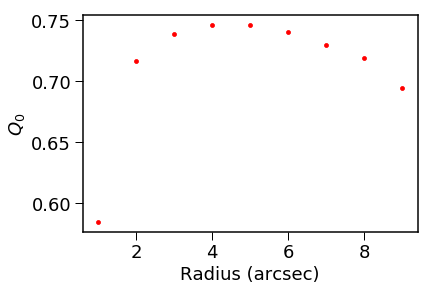

In [108]:
# Compute Q_0 for the i band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_li = []
l_no_m_i = []
r_no_m_i = []

rad = np.arange(1,10)

# Generate random coords
rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down, len(lofar_co))

for k in range(len(rad)):
    q0_i, nl_non_i, nr_non_i = get_Q0(lofar_co, help_coords, rand_coords, float(rad[k]))
    q0_li.append(q0_i)
    l_no_m_i.append(nl_non_i)
    r_no_m_i.append(nr_non_i)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_li)):
    
    print(rad[aa], l_no_m_i[aa], r_no_m_i[aa], q0_li[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_li, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [109]:
# Estimate a mean Q_0 value for the i-band
mean_Q0_vals = []
mean_Q0_i = np.mean(q0_li[2:6])
print(mean_Q0_i)

print("Different Q0 averaging used!")
mean_Q0_i = np.max(q0_li)
mean_Q0_vals.append(mean_Q0_i)

print("Q_0 for r band: " + str(mean_Q0_i))

0.742990041034
Different Q0 averaging used!
Q_0 for r band: 0.746432797383


### Compute LR i-band <a class="anchor" id="run-lr_i"></a>

In [110]:
# Make the subset of MASTER catalogue which are in "i"
master_categ = master[i_only_bool]
print("Sources with i-band detection: " + str(len(master_categ)))

Sources with i-band detection: 1825178


In [111]:
varstat(master_categ[mag_col])

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
23.7864    24.107016  1.24234    1825178    15.6486 35.9043    0         


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [112]:
# Older varstat WITHOUT aperture corrections on 3'' i-mag with 2'' SNR cut
"""Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
23.806032  24.224379  1.48571    1213523    16.112883 28.32097   0 """;

In [113]:
# First match LOFAR to the MASTER catalogue -
# then calculate sigma for all matches in the optical catalogue 
# to a given LOFAR source

# Convert master positions to SkyCoord object
master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                         unit=(u.deg, u.deg), frame='icrs')

# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                           lof_opt_rad*u.arcsec)

# This match returns x of possible counterparts within 15'' of a
# LOFAR source - compute LR for all x sources wrt the LOFAR source
# Take the max value of the LR


# Get the indices of LOFAR which have at least one match - only need to calculate LR for these sources
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))

print("No. of LOFAR sources without a cross-match in {0}'': {1}".format(lof_opt_rad, (len(lofar_co)-len(ind_l_un))))

26870
No. of LOFAR sources without a cross-match in 15.0'': 78


In [114]:
# Functino to compute ML based on magnitude of possible conterpart and the sigma

def apply_ml(i, opt_cat_era, opt_cat_edec, opt_cat_mag, fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ):
    """
    Function which combines previous routines to compute ML values 
    for each ith LOFAR source that has a match within 15'' to opt/NIR catalogue
    
    Parameters:
    -----------
    i : Index of the LOFAR coordinates
    opt_cat_era : All of optical RA errors
    opt_cat_edec : All of optical Dec errors
    opt_cat_mag : All of the optical magnitudes
    fn_opt_indices : Field name of indices in MASTER catalogue
    mean_Q0 : Mean Q0 value for the band
    nm_categ : Cumulative n(m) distribution for the category
    qm_categ : Cumulative q(m) distribution for the category
    nm_bc_categ : Bin centres from the n(m) distribution
    
    Returns:
    --------
    res = [opt_index,dist,lr_value] : [Index into the optical catalogue,
                                        Separation to counterpart,
                                        LR value]
    """
    
    # Get the indices into the corresponding MASTER_category catalogue
    indx_o_match = indx_m[indx_l == i]
    s2d_o = s2d[indx_l == i]  # The 2d separation of the sources from LOFAR source
    
    # Indices corresponding to the FULL MASTER catalogue - the -1 to get into python index notation
    indx_o_master = master_categ["NUMBER"][indx_o_match]
    
    # Get the indices into the ACTUAL optical catalogue
    # indx_o = master_categ[fn_opt_indices][indx_o_match] -- Not used anymore with new catalogue
    
    # Now only select the optical catalogue sources which have an index value in master catalogue
    # indx_o_match = indx_o_match[indx_o != -99.]
    # s2d_o = s2d_o[indx_o != -99.]
    # indx_o = indx_o[indx_o != -99.]
    
    # Get the LOFAR positions and errors
    lofar_ra = final['RA'][i]
    lofar_dec = final['DEC'][i]
    lofar_pa = final['PA'][i]
    lofar_maj_err = final['E_Maj'][i]
    lofar_min_err = final['E_Min'][i]
    
    # Get the optical/NIR counterpart positions and positional errors
    c_ra = master_categ['ALPHA_J2000'][indx_o_match]
    c_dec = master_categ['DELTA_J2000'][indx_o_match]
    c_ra_err = opt_cat_era[indx_o_match]
    c_dec_err = opt_cat_edec[indx_o_match]
    
    # Magnitude of the counterparts
    c_mag = opt_cat_mag[indx_o_match]

    # New corrected angles Gaussian code - sig^2 is actually sigma_0_0 i.e. the average pos err squared?
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    # Compute the LR of all the possible counterparts
    # Set the last argument to False if you do not want to apply the F(r) factor to q(m)
    c_lr = get_lr(c_mag, mean_Q0, nm_categ, qm_categ, np.sqrt(sigma_0_0), 
                  sigma_0_0, det_sigma, s2d_o.arcsec, nm_bc_categ, lof_opt_rad, True)
    
    # Get indices of n=4 maximum values
    # arr.argsort()[-4:][::-1]
    
    # Get the index of the maximum 
    lr_max_ind = np.argmax(c_lr)
    
    
    result = [indx_o_master[lr_max_ind],     # i_band_index into the FULL master catalogue
              (s2d_o.arcsec)[lr_max_ind],    # Separation between counterpart and LOFAR source
              c_lr[lr_max_ind]]              # Max LR value
    
    return result



In [115]:

# A wrapper function to use multiple arguments
def merge_names_unpack(args):
    return apply_ml(*args)

# The number of cpu's to use
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel(i, opt_cat_era, opt_cat_edec, opt_cat_mag, fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ):
    
    pool = mp.Pool(processes=ncpu_use)
    #resu = pool.map(partial(apply_ml, opt_cat_era, opt_cat_edec, opt_cat_mag, 
    #                          fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ), i)

    resu = pool.map(partial(apply_ml, opt_cat_era=opt_cat_era, opt_cat_edec=opt_cat_edec,
                                        opt_cat_mag=opt_cat_mag,fn_opt_indices=fn_opt_indices,
                                        mean_Q0=mean_Q0, nm_categ=nm_categ, qm_categ=qm_categ, nm_bc_categ=nm_bc_categ),i)

    return resu

t4 = time.time()

res = run_parallel(ind_l_un, np.ones(len(master_categ)) * 0.35, np.ones(len(master_categ)) * 0.35,
                   master_categ[mag_col],'does_not_matter',
                   mean_Q0_i, nm_i, qm_i, nm_bc_i)

print(time.time() - t4)

# Create columns in the LOFAR catalogue to store the output of ML in iband
lr_type = "i"
lr_types = []
lr_types.append(lr_type)

final["lr_"+lr_type] = np.nan
final["lr_dist_"+lr_type] = np.nan
final["lr_index_"+lr_type] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_"+lr_type][ind_l_un],
 final["lr_dist_"+lr_type][ind_l_un],
 final["lr_"+lr_type][ind_l_un]) = list(map(list, zip(*res)))

varstat(final["lr_"+lr_type])


8.862663507461548
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
69.164478  15.82743   128.049145 26948      0.0 883.716758 1         


In [116]:
"""8.16303277015686
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
73.245094  22.916586  115.292209 13978      0.0 748.86773  4 """;

###################################################
# All older LR varstats
"""Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
73.364992  22.954099  115.480937 13978      0.0 750.093588 4    
"""

"""8.962059736251831
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
74.186103  23.098952  116.890042 13978      0.0 758.461704 6 """;
varstat(0.2 * np.sqrt(master["X2_IMAGE"]))

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.52029    0.460804   0.47435    3041794    0.057735015372 132.858652 0         


In [117]:
# LR values without the KDE or the new Gaussian correct
"""
23.76141905784607
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
11.274659  4.786558   20.1295    13978      0.0 589.473277 1 """;

In [118]:
varstat(final["lr_i"][final["lr_i"] <= 0.1])

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.006832   2e-06      0.017725   4746       0.0 0.09997    1         


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


### i-band LR Threshold


i-band threshold: 1.6365534631
No of nan LRs: 78
No of sources below threshold: 6814


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Text(0.5, 0, '$LR$')

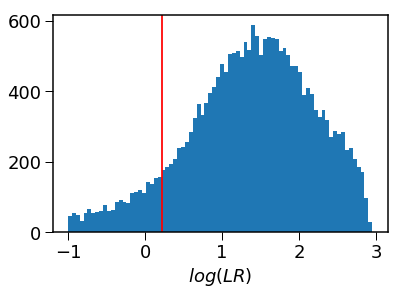

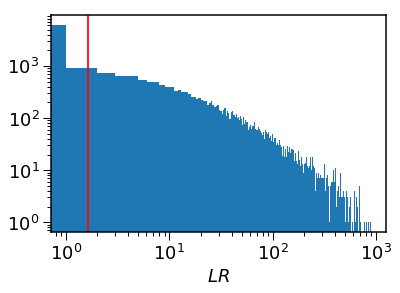

In [119]:
threshold_i = np.nanpercentile(final["lr_"+lr_type], 100*(1 - mean_Q0_i))

print("i-band threshold: "+ str(threshold_i))

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_"+lr_type])])))

print("No of sources below threshold: {0}".format(np.sum(final["lr_"+lr_type] < threshold_i)))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_"+lr_type]), 0.05)
mask = (~np.isnan(final["lr_"+lr_type])) & (final["lr_"+lr_type]>0)
plt.hist(np.log10(final["lr_"+lr_type][mask]), bins=lr_be)
plt.axvline(np.log10(threshold_i), 0, 100000, color='r')
plt.xlabel('$log(LR)$')

lr_n, lr_e, _ = return_hist_par(1, final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])])

fig = plt.figure()
plt.hist(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])], bins=lr_e)
plt.axvline((threshold_i), 0, 1, color='r')

# plt.xscale('log')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$LR$')

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
473.795793 445.819238 132.28389  1799       300.08910793 883.716758 0         
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
22.5287    22.878365  1.76246    26870      15.7002 25.4257    0         


Text(0, 0.5, '$log(LR)$')

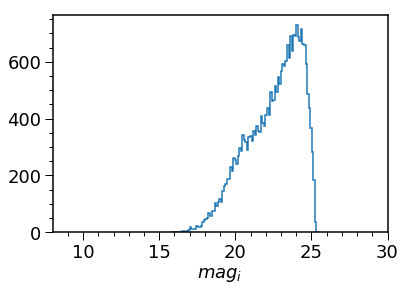

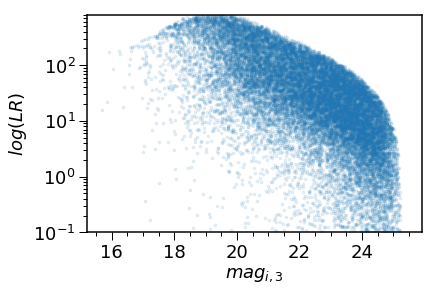

In [120]:
high_lr = final["lr_"+lr_type] > 300
varstat(final["lr_"+lr_type][high_lr])

good_lr_ind = (final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)
varstat(master[mag_col][(final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)])

_, me, mc = return_hist_par(0.1, master[mag_col][good_lr_ind])
fig, ax = make_fig()
plt.hist(master[mag_col][good_lr_ind], bins=me, histtype='step', lw=1.5)
plt.xlabel('$mag_{i}$')
plt.xlim([8, 30])

fig, ax = make_fig()
plt.scatter(master[mag_col][good_lr_ind], (final["lr_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]),
            s=7, alpha=0.1)
plt.yscale('log')
plt.ylim([0.1, 800])
plt.xlabel('$mag_{i,3}$')
plt.ylabel('$log(LR)$')

---

## Spitzer 4.5$\mu$m <a class="anchor" id="k-analysis"></a>

### Define the flux and magnitude columns to use

## Filter the LOFAR and optical catalogue to within the SERVS region

In [121]:
# Filter the LOFAR catalouge
lofar_sind = inMoc(deepfull["RA"], deepfull["DEC"], moc_se2)
servs_ind = inMoc(master["ALPHA_J2000"], master["DELTA_J2000"], moc_se2)

print("LOFAR sources in the SERVS MOC: {0}".format(np.sum(lofar_sind)))
print("MASTER catalogue sources in SERVS MOC: {0}".format(np.sum(servs_ind)))

LOFAR sources in the SERVS MOC: 18442
MASTER catalogue sources in SERVS MOC: 1016618


In [122]:
filt = "se2"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

snr_band = master[sflux_col] / master[seflux_col]
snr_th = 3.
null_mag = -99

In [123]:
master_rect_ind = servs_ind & (master[mag_col] != null_mag) & (snr_band >= snr_th)
print(np.sum(master_rect_ind))
print("No. of SERVS sources in rectangular area: " + str(np.sum(master_rect_ind)))

395058
No. of SERVS sources in rectangular area: 395058


### n(m) <a class="anchor" id="comp-nm_k"></a>

Properties of n(m): 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.001523   0.000164   0.002062   223        6.26885250597e-08 0.005469   0         


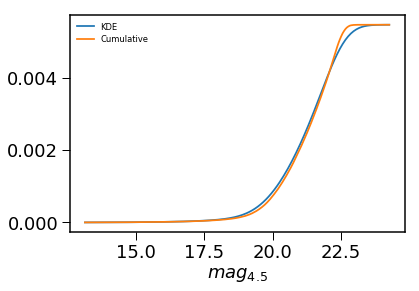

In [124]:
# Get the bin_list for computing n(m) for g band
_, nm_be_ir, nm_bc_ir = return_hist_par(0.05, master[mag_col][master_rect_ind])

# nm_be_ir, nm_bc_ir = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the g band
servs_area = moc_se2.area_sq_deg*3600*3600
nm_ir_old = get_n_m(master[mag_col][master_rect_ind], nm_be_ir, servs_area)

nm_ir = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_ir, area=servs_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m): ")
varstat(np.cumsum(nm_ir))

fig = plt.figure()

plt.plot(nm_bc_ir, np.cumsum(nm_ir), label='KDE')
plt.plot(nm_bc_ir, nm_ir_old, label='Cumulative')
plt.xlabel('$mag_{4.5}$')
plt.legend()

In [125]:
# Write the n(m) distribution to pckl file to compare with the other fields
# pickle.dump([nm_bc_ir, nm_ir, nm_ir_old], open("EN1_nm_ir_3asec.pckl", "wb"))

### q(m) <a class="anchor" id="comp-qm_k"></a>

In [126]:
# Previous definition
# ir_only_bool_servs = ((master["flag_clean"] == 1) & (master[mag_col] != null_mag) & servs_ind & (snr_band >= snr_th))

ir_only_bool_servs = (master[mag_col] != null_mag) & (snr_band >= snr_th)
print(np.sum(ir_only_bool_servs))

# ir_only_bool_servs = servs_ind & (master[mag_col] != null_mag)

# Optical Coordinates
ir_coords_se = SkyCoord(master['ALPHA_J2000'][ir_only_bool_servs], 
                       master['DELTA_J2000'][ir_only_bool_servs],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of IR sources used for q(m) calculation: {0}".format(np.sum(ir_only_bool_servs)))

lofar_co_se = SkyCoord(deepfull["RA"][lofar_sind], deepfull["DEC"][lofar_sind],
                      unit='deg', frame='icrs')
print("No. of LOFAR sources used for q(m) and Q0 calculation: {0}".format(len(lofar_co_se)))

395060
No. of IR sources used for q(m) calculation: 395060
No. of LOFAR sources used for q(m) and Q0 calculation: 18442


Unique opt_ind:  28961
Unique LOFAR ind:  17253
q(m) statistics: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.390921   0.120743   0.428628   223        0.0 1.0        18        
2315323
real m
1827138.58337


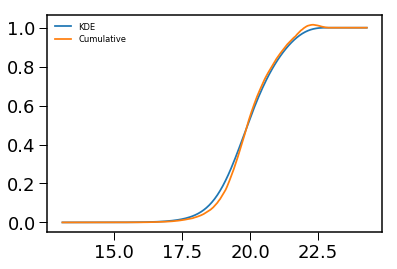

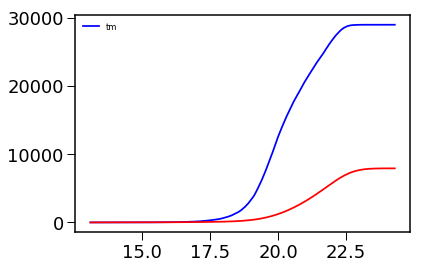

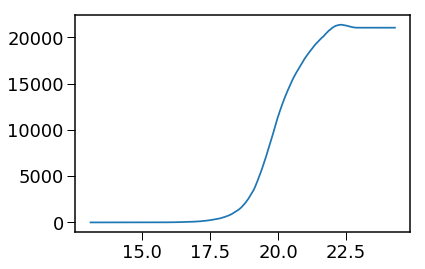

In [127]:
RMAX = 5.

# This is only estimated in the SERVS region
qm_ir_old, tm_ir, rm_ir = get_q_m(lofar_co_se, ir_coords_se, RMAX,
               master[mag_col][ir_only_bool_servs], nm_be_ir, servs_area, nm_ir_old)

qm_ir = estimate_q_m_kde(master[mag_col][ir_only_bool_servs], nm_bc_ir, nm_ir,
                        lofar_co_se, ir_coords_se, RMAX, bandwidth=0.5)

fig = plt.figure()

plt.plot(nm_bc_ir, np.cumsum(qm_ir), label='KDE')
plt.plot(nm_bc_ir, qm_ir_old, label='Cumulative')
plt.legend()


fig = plt.figure()

plt.plot(nm_bc_ir, tm_ir, color='b', label='tm')
plt.plot(nm_bc_ir, np.pi*RMAX**2 * np.cumsum(nm_ir) * len(lofar_co_se), color='r')
plt.legend()

fig = plt.figure()

plt.plot(nm_bc_ir, rm_ir)

print("q(m) statistics: ")
varstat(np.cumsum(qm_ir))

print(np.sum(tm_ir))
print("real m")
print(np.sum(rm_ir))

In [128]:
# Write the q(m) distribution to pckl file to compare with the other fields
# pickle.dump([nm_bc_ir, qm_ir, qm_ir_old], open("EN1_qm_ir_3asec.pckl", "wb"))

## q(m) for SWIRE sources

In [129]:
lofar_sind = inMoc(deepfull["RA"], deepfull["DEC"], moc_sw_only)
swire_ind = inMoc(master["ALPHA_J2000"], master["DELTA_J2000"], moc_sw_only)

print("LOFAR sources in the SWIRE only MOC: {0}".format(np.sum(lofar_sind)))
print("MASTER catalogue sources in SWIRE only MOC: {0}".format(np.sum(swire_ind)))

filt = "sw2"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

snr_band = master[sflux_col] / master[seflux_col]
snr_th = 3.
null_mag = -99

master_rect_ind_sw = swire_ind & (master[mag_col] != null_mag) & (snr_band >= snr_th)
print(np.sum(master_rect_ind_sw))
print("No. of SERVS sources in rectangular area: " + str(np.sum(master_rect_ind_sw)))

LOFAR sources in the SWIRE only MOC: 13030
MASTER catalogue sources in SWIRE only MOC: 976229
279694
No. of SERVS sources in rectangular area: 279694


Properties of n(m): 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.001231   0.000146   0.001617   253        3.78497084886e-08 0.004015   0         


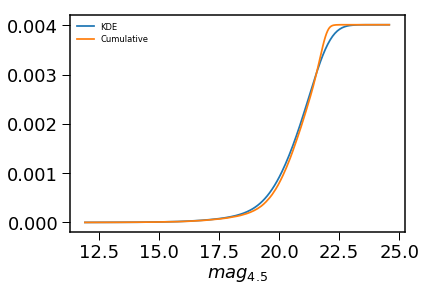

In [130]:
#run for SWIRE sources in the same region
#DON'T RERUN

# Get the bin_list for computing n(m) for g band
_, nm_be_ir_sw, nm_bc_ir_sw = return_hist_par(0.05, master[mag_col][master_rect_ind_sw])

# nm_be_ir, nm_bc_ir = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the g band
swire_area = moc_sw_only.area_sq_deg*3600*3600
nm_ir_old_sw = get_n_m(master[mag_col][master_rect_ind_sw], nm_be_ir_sw, swire_area)

nm_ir_sw = get_n_m_kde(master[mag_col][master_rect_ind_sw], nm_bc_ir_sw, area=swire_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m): ")
varstat(np.cumsum(nm_ir_sw))

fig = plt.figure()

plt.plot(nm_bc_ir_sw, np.cumsum(nm_ir_sw), label='KDE')
plt.plot(nm_bc_ir_sw, nm_ir_old_sw, label='Cumulative')
plt.xlabel('$mag_{4.5}$')
plt.legend()

576504
No. of IR sources used for q(m) calculation: 576504
No. of LOFAR sources used for q(m) and Q0 calculation: 13030
Unique opt_ind:  19193
Unique LOFAR ind:  12464
q(m) statistics: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.377202   0.07334    0.432217   253        0.0 1.0        6         
1748864
real m
1432125.14499


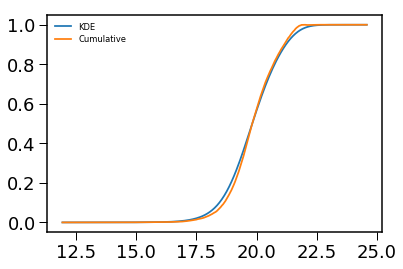

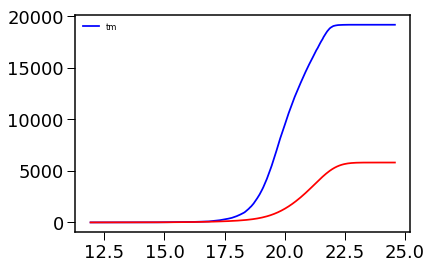

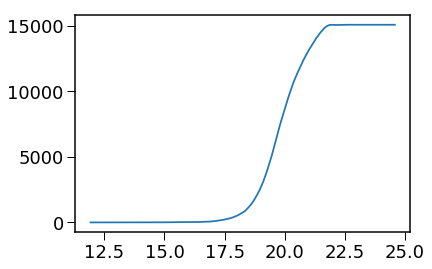

In [131]:
#run for SWIRE sources in the same region
#DON'T RERUN

# Previous definition
# ir_only_bool_servs = ((master["flag_clean"] == 1) & (master[mag_col] != null_mag) & servs_ind & (snr_band >= snr_th))

ir_only_bool_swire = (master[mag_col] != null_mag) & (snr_band >= snr_th)
print(np.sum(ir_only_bool_swire))

# ir_only_bool_servs = servs_ind & (master[mag_col] != null_mag)

# Optical Coordinates
ir_coords_sw = SkyCoord(master['ALPHA_J2000'][ir_only_bool_swire], 
                       master['DELTA_J2000'][ir_only_bool_swire],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of IR sources used for q(m) calculation: {0}".format(np.sum(ir_only_bool_swire)))

lofar_co_sw = SkyCoord(deepfull["RA"][lofar_sind], deepfull["DEC"][lofar_sind],
                      unit='deg', frame='icrs')
print("No. of LOFAR sources used for q(m) and Q0 calculation: {0}".format(len(lofar_co_sw)))

RMAX = 5.

# This is only estimated in the SERVS region
qm_ir_old_sw, tm_ir_sw, rm_ir_sw = get_q_m(lofar_co_sw, ir_coords_sw, RMAX,
               master[mag_col][ir_only_bool_swire], nm_be_ir_sw, swire_area, nm_ir_old_sw)

qm_ir_sw = estimate_q_m_kde(master[mag_col][ir_only_bool_swire], nm_bc_ir_sw, nm_ir_sw,
                        lofar_co_sw, ir_coords_sw, RMAX, bandwidth=0.5)

fig = plt.figure()

plt.plot(nm_bc_ir_sw, np.cumsum(qm_ir_sw), label='KDE')
plt.plot(nm_bc_ir_sw, qm_ir_old_sw, label='Cumulative')
plt.legend()


fig = plt.figure()

plt.plot(nm_bc_ir_sw, tm_ir_sw, color='b', label='tm')
plt.plot(nm_bc_ir_sw, np.pi*RMAX**2 * np.cumsum(nm_ir_sw) * len(lofar_co_se), color='r')
plt.legend()

fig = plt.figure()

plt.plot(nm_bc_ir_sw, rm_ir_sw)

print("q(m) statistics: ")
varstat(np.cumsum(qm_ir_sw))

print(np.sum(tm_ir_sw))
print("real m")
print(np.sum(rm_ir_sw))

## HELP data

In [132]:
servs_ind_help = inMoc(helpcat["ra"], helpcat["dec"], moc_se2)

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Properties of n(m): 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.00169    0.000164   0.002419   223        7.32690832633e-08 0.007295   0         


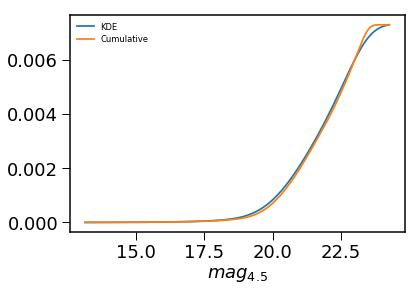

In [133]:
master_rect_ind = servs_ind_help & (~np.isnan(helpcat['m_ap_irac_i2'])) & (helpcat['f_ap_irac_i2']/helpcat['ferr_ap_irac_i2']>3)

# Get the bin_list for computing n(m) for g band
#_, nm_be_ir, nm_bc_ir = return_hist_par(0.05, master[mag_col][master_rect_ind])

# nm_be_ir, nm_bc_ir = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the g band
servs_area = moc_se2.area_sq_deg*3600*3600
nm_ir_old_help = get_n_m(helpcat['m_ap_irac_i2'][master_rect_ind], nm_be_ir, servs_area)

nm_ir_help = get_n_m_kde(helpcat['m_ap_irac_i2'][master_rect_ind], nm_bc_ir, area=servs_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m): ")
varstat(np.cumsum(nm_ir_help))

fig = plt.figure()

plt.plot(nm_bc_ir, np.cumsum(nm_ir_help), label='KDE')
plt.plot(nm_bc_ir, nm_ir_old_help, label='Cumulative')
plt.xlabel('$mag_{4.5}$')
plt.legend()

In [134]:
# Previous definition
# ir_only_bool_servs = ((master["flag_clean"] == 1) & (master[mag_col] != null_mag) & servs_ind & (snr_band >= snr_th))

ir_only_bool_servs = servs_ind_help & (~np.isnan(helpcat['m_ap_irac_i2']))
print(np.sum(ir_only_bool_servs))

# ir_only_bool_servs = servs_ind & (master[mag_col] != null_mag)

# Optical Coordinates
ir_coords_se_help = SkyCoord(helpcat['ra'][ir_only_bool_servs], 
                       helpcat['dec'][ir_only_bool_servs],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of IR sources used for q(m) calculation: {0}".format(np.sum(ir_only_bool_servs)))

lofar_co_se = SkyCoord(deepfull["RA"][lofar_sind], deepfull["DEC"][lofar_sind],
                      unit='deg', frame='icrs')
print("No. of LOFAR sources used for q(m) and Q0 calculation: {0}".format(len(lofar_co_se)))

750904
No. of IR sources used for q(m) calculation: 750904
No. of LOFAR sources used for q(m) and Q0 calculation: 13030


Unique opt_ind:  9
Unique LOFAR ind:  9
q(m) statistics: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
nan        nan        nan        223        nan nan        0         
748
real m
0.0


/mnt/pact/im281/FIR-group/Ian/lofar/deep_fields/Lockman/mlrun1_bootes.py:251: RuntimeWarning: invalid value encountered in true_divide
  return real_m/real_m[-1], np.cumsum(total_m), real_m
/mnt/pact/im281/FIR-group/Ian/lofar/deep_fields/Lockman/mlrun1_bootes.py:862: RuntimeWarning: invalid value encountered in true_divide
  return real_m/np.sum(real_m)
/mnt/pact/im281/FIR-group/Ian/lofar/deep_fields/Lockman/mlrun1_bootes.py:58: RuntimeWarning: Mean of empty slice
  stat_to_print = [np.nanmean(distribution),np.nanmedian(distribution),
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/mnt/pact/im281/FIR-group/Ian/lofar/deep_fields/Lockman/mlrun1_bootes.py:59: RuntimeWarning: All-NaN axis encountered


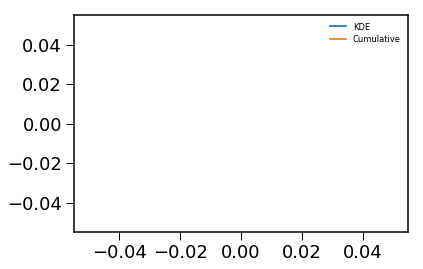

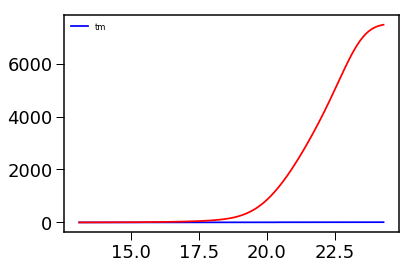

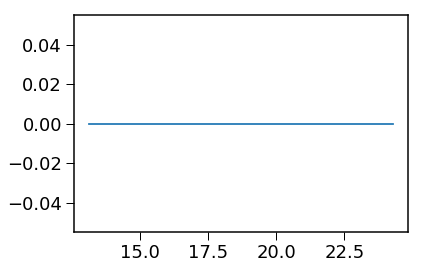

In [135]:
RMAX = 5.

# This is only estimated in the SERVS region
qm_ir_old_help, tm_ir_help, rm_ir_help = get_q_m(lofar_co_se, ir_coords_se_help, RMAX,
               helpcat['m_ap_irac_i2'][ir_only_bool_servs], nm_be_ir, servs_area, nm_ir_old_help)

qm_ir_help = estimate_q_m_kde(helpcat['m_ap_irac_i2'][ir_only_bool_servs], nm_bc_ir, nm_ir_help,
                        lofar_co_se, ir_coords_se_help, RMAX, bandwidth=0.5)

fig = plt.figure()

plt.plot(nm_bc_ir, np.cumsum(qm_ir_help), label='KDE')
plt.plot(nm_bc_ir, qm_ir_old_help, label='Cumulative')
plt.legend()


fig = plt.figure()

plt.plot(nm_bc_ir, tm_ir_help, color='b', label='tm')
plt.plot(nm_bc_ir, np.pi*RMAX**2 * np.cumsum(nm_ir_help) * len(lofar_co_se), color='r')
plt.legend()

fig = plt.figure()

plt.plot(nm_bc_ir, rm_ir_help)

print("q(m) statistics: ")
varstat(np.cumsum(qm_ir_help))

print(np.sum(tm_ir_help))
print("real m")
print(np.sum(rm_ir_help))

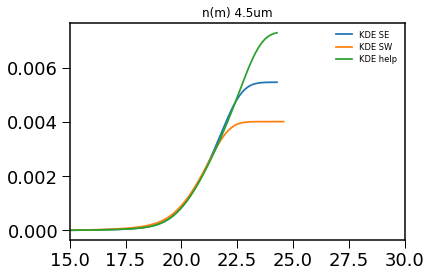

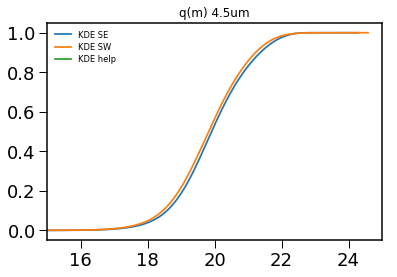

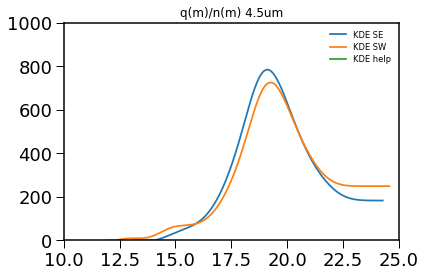

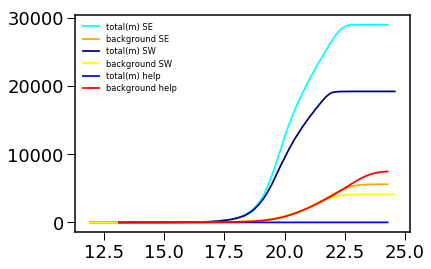

In [136]:
plt.plot(nm_bc_ir, np.cumsum(nm_ir), label='KDE SE')
plt.plot(nm_bc_ir_sw, np.cumsum(nm_ir_sw), label='KDE SW')
#plt.plot(nm_bc_i, np.log10(nm_i_old), label='Cumulative')
plt.plot(nm_bc_ir, np.cumsum(nm_ir_help), label='KDE help')
#plt.plot(nm_bc_i, np.log10(nm_i_old_help), label='Cumulative help')
#plt.plot(nm_bc_i-0.025, np.log10(help_opt[0]), label='help')
#plt.ylim(-6,-1.6)
plt.xlim(15,30)
plt.title('n(m) 4.5um')
plt.legend()
plt.show()

plt.plot(nm_bc_ir, np.cumsum(qm_ir), label='KDE SE')
plt.plot(nm_bc_ir_sw, np.cumsum(qm_ir_sw), label='KDE SW')
#plt.plot(nm_bc_ir, qm_ir_old, label='Cumulative')
plt.plot(nm_bc_ir, np.cumsum(qm_ir_help), label='KDE help')
plt.legend()
plt.title("q(m) 4.5um")
plt.xlim(15,25)
plt.show()

plt.plot(nm_bc_ir, np.cumsum(qm_ir)/np.cumsum(nm_ir), label='KDE SE')
plt.plot(nm_bc_ir_sw, np.cumsum(qm_ir_sw)/np.cumsum(nm_ir_sw), label='KDE SW')
#plt.plot(nm_bc_ir, qm_ir_old/nm_ir_old, label='Cumulative')
plt.plot(nm_bc_ir, np.cumsum(qm_ir_help)/np.cumsum(nm_ir_help), label='KDE help')
plt.legend()
plt.title("q(m)/n(m) 4.5um")
plt.xlim(10,25)
plt.ylim(0,1000)
plt.show()

plt.plot(nm_bc_ir, tm_ir, color='cyan', label='total(m) SE')
plt.plot(nm_bc_ir, np.pi * RMAX**2 * np.cumsum(nm_ir) * (len(lofar_co_se)), color='orange', label='background SE')
plt.plot(nm_bc_ir_sw, tm_ir_sw, color='navy', label='total(m) SW')
plt.plot(nm_bc_ir_sw, np.pi * RMAX**2 * np.cumsum(nm_ir_sw) * (len(lofar_co_se)), color='yellow', label='background SW')
plt.plot(nm_bc_ir, tm_ir_help, color='b', label='total(m) help')
plt.plot(nm_bc_ir, np.pi * RMAX**2 * np.cumsum(nm_ir_help) * (len(lofar_co_se)), color='r', label='background help')
plt.legend()

## Compute Q$_0$ <a class="anchor" id="comp-Q0_k"></a>

In [137]:
len(lofar_co_se)

13030

ratio of the random generation area compared to the moc area is: 5.382032588539873
13030
Timetaken: 36.32633113861084
Radius Blanks Random Blanks Q_0
1 13029 12780 -0.019483568075117308
2 13029 12094 -0.07731106333719207
3 13029 11106 -0.17314964883846562
4 13029 9942 -0.3105009052504526
5 13029 8672 -0.5024215867158672
6 13027 7298 -0.7850095916689503
7 13026 6094 -1.1375123071873974
8 13026 4931 -1.6416548367471102
9 13024 3989 -2.2649786914013537
10 13024 3197 -3.0738192055051607
11 13023 2533 -4.141334386103435
12 13021 2022 -5.439663699307617
13 13018 1621 -7.030845157310303
14 13017 1339 -8.721433905899925
15 13012 1131 -10.504862953138815
16 13010 988 -12.168016194331983
17 13008 882 -13.748299319727892
18 13005 810 -15.055555555555557
19 13005 770 -15.88961038961039


Text(0, 0.5, '$Q_0$')

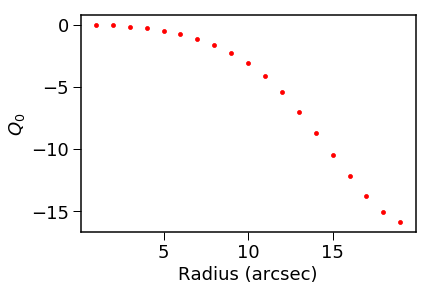

In [138]:
# Compute Q_0 for the g band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_lir = []
l_no_m_lir = []
r_no_m_lir = []

rad = np.arange(1,20)

# DON'T GENERATE THE RANDOM COORDINATES AGAIN

# Generate random coords
ra_down = 159
dec_down = 56
ra_up = 165
dec_up = 61


# rand_coords = generate_rand_pos_servs(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_co_se))
rand_coords = gen_rand_cat_inMOC(len(lofar_co_se), ra_up,ra_down,dec_up,dec_down, moc_se2)
print(len(rand_coords))

for k in range(len(rad)):
    q0_ir, nl_non_ir, nr_non_ir = get_Q0(lofar_co_se, ir_coords_se, rand_coords, float(rad[k]))
    q0_lir.append(q0_ir)
    l_no_m_lir.append(nl_non_ir)
    r_no_m_lir.append(nr_non_ir)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_lir)):
    
    print(rad[aa], l_no_m_lir[aa], r_no_m_lir[aa], q0_lir[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_lir, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [139]:
"""
Timetaken: 6.642718553543091
Radius Blanks Random Blanks Q_0
1 1782 6226 0.7137809187279152
2 686 5828 0.8822923816060398
3 393 5183 0.9241751881149913
4 267 4406 0.939400817067635
5 206 3573 0.9423453680380632
6 163 2817 0.9421370252041179
7 130 2095 0.9379474940334129
8 94 1549 0.9393156875403486
9 67 1070 0.9373831775700935
"""


"""Timetaken: 0.9932589530944824
Radius Blanks Random Blanks Q_0
1 1334 4576 0.708479020979021
2 545 4272 0.8724250936329588
3 334 3850 0.9132467532467532
4 263 3331 0.9210447313119183
5 221 2743 0.919431279620853
6 190 2161 0.91207774178621
7 162 1684 0.9038004750593824
8 139 1230 0.8869918699186992
9 119 869 0.8630609896432682""";

In [140]:
Q0_test = np.mean(q0_lir[3:6])
print(Q0_test)
del Q0_test

-0.532644027878


In [141]:
# Estimate a mean Q_0 value for the i-band
mean_Q0_ir = np.mean(q0_lir[3:6])

print("Using the MAX Q0 value instead!")
mean_Q0_ir = np.max(q0_lir)
print("Q_0 for 4.5um: " + str(mean_Q0_ir))
mean_Q0_vals.append(mean_Q0_ir)

Using the MAX Q0 value instead!
Q_0 for 4.5um: -0.0194835680751


## Compute Q0 for SWIRE only region

ratio of the random generation area compared to the moc area is: 12.277367131939156
13030
Timetaken: 41.13369393348694
Radius Blanks Random Blanks Q_0
1 3959 12869 0.6923614888491725
2 1590 12369 0.8714528256124181
3 985 11609 0.9151520372125075
4 709 10691 0.9336825367131232
5 566 9569 0.9408506636012123
6 468 8428 0.9444708115804461
7 390 7260 0.9462809917355371
8 325 6131 0.9469907029848312
9 272 5054 0.9461812425801346
10 224 4091 0.9452456612075287
11 171 3294 0.9480874316939891
12 129 2556 0.9495305164319249
13 102 1978 0.948432760364004
14 72 1489 0.951645399597045
15 54 1065 0.9492957746478873
16 44 759 0.9420289855072463
17 28 540 0.9481481481481482
18 19 359 0.947075208913649
19 13 231 0.9437229437229437


Text(0, 0.5, '$Q_0$')

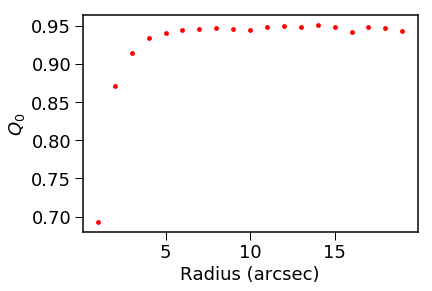

In [142]:
# Compute Q_0 for the g band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_lir = []
l_no_m_lir = []
r_no_m_lir = []

rad = np.arange(1,20)

# DON'T GENERATE THE RANDOM COORDINATES AGAIN

# Generate random coords
ra_down = 156
dec_down = 55
ra_up = 167
dec_up = 61


# rand_coords = generate_rand_pos_servs(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_co_se))
rand_coords = gen_rand_cat_inMOC(len(lofar_co_sw), ra_up,ra_down,dec_up,dec_down, moc_sw_only)
print(len(rand_coords))

for k in range(len(rad)):
    q0_ir, nl_non_ir, nr_non_ir = get_Q0(lofar_co_sw, ir_coords_sw, rand_coords, float(rad[k]))
    q0_lir.append(q0_ir)
    l_no_m_lir.append(nl_non_ir)
    r_no_m_lir.append(nr_non_ir)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_lir)):
    
    print(rad[aa], l_no_m_lir[aa], r_no_m_lir[aa], q0_lir[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_lir, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [143]:
Q0_test = np.mean(q0_lir[3:6])
print(Q0_test)
del Q0_test

# Estimate a mean Q_0 value for the i-band
mean_Q0_ir = np.mean(q0_lir[3:6])

print("Using the MAX Q0 value instead!")
mean_Q0_ir = np.max(q0_lir)
print("Q_0 for 4.5um: " + str(mean_Q0_ir))
mean_Q0_vals.append(mean_Q0_ir)

0.939668003965
Using the MAX Q0 value instead!
Q_0 for 4.5um: 0.951645399597


## HELP SERVS Q0

ratio of the random generation area compared to the moc area is: 5.382032588539873
Timetaken: 35.952277183532715
Radius Blanks Random Blanks Q_0
1 13027 12599 -0.03397095007540285
2 13023 11403 -0.14206787687450673
3 13023 9602 -0.35627994167881694
4 13022 7501 -0.7360351953072923
5 13021 5498 -1.368315751182248
6 13019 3825 -2.4036601307189542
7 13012 2577 -4.049282110981761
8 13010 1676 -6.762529832935561
9 13004 1099 -10.832575068243859


Text(0, 0.5, '$Q_0$')

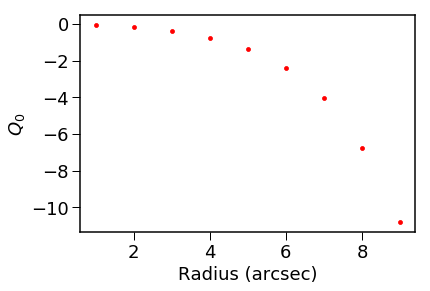

In [144]:
# Compute Q_0 for the g band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_lir = []
l_no_m_lir = []
r_no_m_lir = []

rad = np.arange(1,10)

# DON'T GENERATE THE RANDOM COORDINATES AGAIN

# Generate random coords
ra_down = 159
dec_down = 56
ra_up = 165
dec_up = 61


# rand_coords = generate_rand_pos_servs(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_co_se))
rand_coords = gen_rand_cat_inMOC(len(lofar_co_se), ra_up,ra_down,dec_up,dec_down, moc_se2)

for k in range(len(rad)):
    q0_ir, nl_non_ir, nr_non_ir = get_Q0(lofar_co_se, ir_coords_se_help, rand_coords, float(rad[k]))
    q0_lir.append(q0_ir)
    l_no_m_lir.append(nl_non_ir)
    r_no_m_lir.append(nr_non_ir)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_lir)):
    
    print(rad[aa], l_no_m_lir[aa], r_no_m_lir[aa], q0_lir[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_lir, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [145]:
Q0_test = np.mean(q0_lir[3:6])
print(Q0_test)
del Q0_test

-1.50267035907


# Redefine the optical and LOFAR catalogue to be in the full SWIRE region

In [146]:
# Redefine the IR magnitude to be taken from the full SWIRE 4.5um channel

filt = "sw2"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

snr_band = master[sflux_col] / master[seflux_col]

In [147]:
np.sum(snr_band >= snr_th)

576507

In [148]:
# Redefine the LOFAR and optical coordinates to be in the full SWIRE region

ir_only_bool = ((master["flag_clean"] == 1) & (master[mag_col] != null_mag) & (snr_band >= snr_th))

# ir_only_bool = (master[sflux_col] / master[seflux_col] >= snr_th) & (master["flag_clean"] == 1) & (master[mag_col] != null_mag)

# Optical Coordinates
ir_coords = SkyCoord(master['ALPHA_J2000'][ir_only_bool], 
                       master['DELTA_J2000'][ir_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of IR sources used for LR cross-match: {0}".format(np.sum(ir_only_bool)))
print("No. of LOFAR sources used for LR cross-match: {0}".format(len(lofar_co)))

No. of IR sources used for LR cross-match: 535488
No. of LOFAR sources used for LR cross-match: 26948


## Compute LR for $4.5\mu$m filter <a class="anchor" id="comp-lr_k"></a>

In [149]:
# Define the sub catalogue of master sources that are 4.5um sources (SWIRE and SERVS)
master_categ = master[ir_only_bool]
print("Sources with 4.5um detection: " + str(len(master_categ)))

Sources with 4.5um detection: 535488


In [150]:
# First match LOFAR to the MASTER catalogue -
# then calculate sigma for all matches in the optical catalogue 
# to a given LOFAR source

# Convert master positions to SkyCoord object
master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                         unit=(u.deg, u.deg), frame='icrs')

# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                           lof_opt_rad*u.arcsec)

# This match returns x of possible counterparts within 15'' of a
# LOFAR source - compute LR for all x sources wrt the LOFAR source
# Take the max value of the LR


# Get the indices of LOFAR which have at least one match - only need to calculate LR for these sources
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))
print("No. of radio sources without any positional cross-match: {0}".format(len(lofar_co) - len(ind_l_un)))

26108
No. of radio sources without any positional cross-match: 840


In [151]:
# Run the ML function
t4 = time.time()

res = run_parallel(ind_l_un, 0.35 * np.ones(len(master_categ)), 0.35 * np.ones(len(master_categ)),
                        master_categ[mag_col], 'does_not_matter',mean_Q0_ir, nm_ir, qm_ir, nm_bc_ir)

print(time.time() - t4)

lr_type = "ch2"
lr_types.append(lr_type)

# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_"+lr_type] = np.nan
final["lr_dist_"+lr_type] = np.nan
final["lr_index_"+lr_type] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_"+lr_type][ind_l_un],
 final["lr_dist_"+lr_type][ind_l_un],
 final["lr_"+lr_type][ind_l_un]) = list(map(list, zip(*res)))

# Convert the index into ints as the map converts them to float
# final["lr_index_K"] = final["lr_index_K"].astype(int)

varstat(final["lr_"+lr_type])

4.588962078094482
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
184.103358 83.118022  236.273917 26948      0.0 1279.202914 30        


In [152]:
"""
5.427373170852661
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
176.061729 96.505636  205.628873 13978      0.0 1161.655159 3  
"""

##############################################################
# All older runs with older catalogue (WITHOUT) aperture corrections
"""
# Using isinSERVS
5.24103569984436
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
167.824593 92.400255  195.642543 13978      0.0 1108.143249 3  """  

# Run with KDE and Gaussian correct, using 0.2 * ERRA/B_IMAGE
"""Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
174.291738 119.257662 174.654058 13978      0.0 976.553256 3    """

# Run without KDE and without the new Gaussian correct
"""
23.090405464172363
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
210.802909 202.698419 133.001753 13978      0.0 624.728237 6"""; 

ch2-band threshold: 2.08433908692e-13
No of nan LRs: 840
No of sources below threshold: 1263
No of sources with LR=0: 30


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Text(0.5, 0, '$log(LR)$')

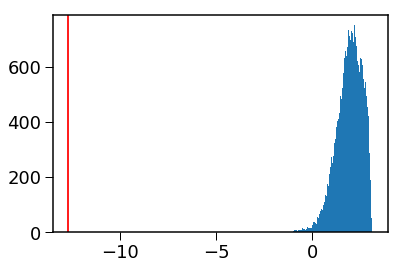

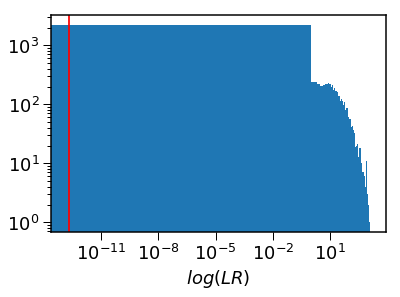

In [153]:
threshold_ch2 = np.nanpercentile(final["lr_"+lr_type], 100*(1 - mean_Q0_ir))

print("ch2-band threshold: "+ str(threshold_ch2))

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_"+lr_type])])))

print("No of sources below threshold: {0}".format(np.sum(final["lr_"+lr_type] < threshold_ch2)))

print('No of sources with LR=0: {}'.format(np.sum(final['lr_'+lr_type]==0)))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_"+lr_type]), 0.05)
mask = (~np.isnan(final["lr_"+lr_type])) & (final["lr_"+lr_type]>0)
plt.hist(np.log10(final["lr_"+lr_type][mask]), bins=lr_be)
plt.axvline(np.log10(threshold_ch2), 0, 100000, color='r')

lr_n, lr_e, _ = return_hist_par(1, final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])])
# print(lr_n)

fig = plt.figure()
plt.hist(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])], bins=lr_e)
plt.axvline((threshold_ch2), 0, 100000, color='r')

plt.xscale('log')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$log(LR)$')

In [154]:
mean_Q0_ir

0.95164539959704497

In [155]:
th_test = np.nanpercentile(final["lr_"+lr_type][~np.isnan(final["lr_ch2"])], 100*(1 - mean_Q0_ir))

In [156]:
1 - np.sum((np.isnan(final["lr_ch2"])) | (final["lr_ch2"] < th_test)) / len(final)

0.9219608134184355

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
939.795311 914.145708 106.686686 956        800.291502434 1279.202914 0         
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
19.7874    19.791668  1.04931    26108      11.8947 22.4839    0         


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$log(LR)$')

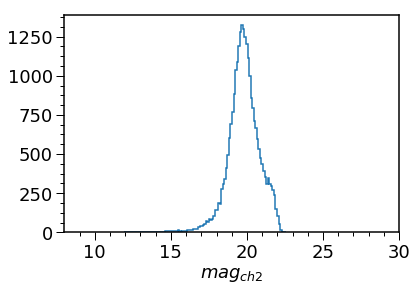

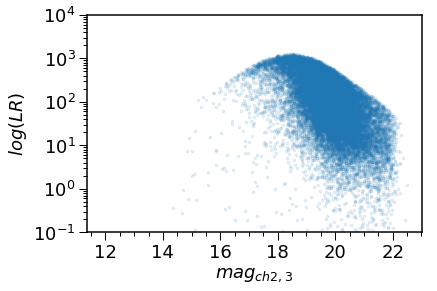

In [157]:
high_lr = final["lr_"+lr_type] > 800
varstat(final["lr_"+lr_type][high_lr])

good_lr_ind = (final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)
varstat(master[mag_col][(final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)])

_, me, mc = return_hist_par(0.1, master[mag_col][good_lr_ind])
fig, ax = make_fig()
plt.hist(master[mag_col][good_lr_ind], bins=me, histtype='step', lw=1.5)
plt.xlabel('$mag_{ch2}$')
plt.xlim([8, 30])

fig, ax = make_fig()
plt.scatter(master[mag_col][good_lr_ind], (final["lr_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]),
            s=7, alpha=0.1)
plt.yscale('log')
plt.ylim([0.1, 10000])
plt.xlabel('$mag_{ch2,3}$')
plt.ylabel('$log(LR)$')

---

# Run until here for now #

In [158]:
# Make a directory based on when the code is run to store output

if workflow_iter:
    add_str = "_workflow"
else:
    add_str = ""

# Make the general directory to store the catalogue
if os.path.exists(strftime("run1_matches"+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("run1_matches"+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1])
    
    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num+1)
    print(outdir_name)
    os.makedirs(outdir_name)
else:
    outdir_name = strftime("run1_matches"+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)

In [159]:
outdir_name

'run1_matches_workflow/21_06_2019_1'

In [160]:
# Edit sources such that soucres below threshold are nans

# run_type = "1_faint"
run_type = "1"
field = "EN1"

# Write the matches before setting threshold to be nan's
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type + cat_type, format='ascii', overwrite=True)
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'.fits', format='fits', overwrite=True)

final["lr_index_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_index_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final["lr_dist_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_dist_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final["lr_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'_nanth', format='ascii', overwrite=True)
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'_nanth.fits', format='fits', overwrite=True)

print(time.time() - ts)
print("Mean Q0s: ")
print(mean_Q0_vals)

run1_filts = lr_types

# Write the mean Q0s to pckl file too
pickle.dump([run1_filts, mean_Q0_vals], open(outdir_name + "/run1_filts_and_mean_Q0.pckl", "wb"))

4908.77972817421
Mean Q0s: 
[0.74643279738289137, -0.019483568075117308, 0.95164539959704497]


In [161]:
good_lr_i = final["lr_i"] >= threshold_i
good_lr_ir = final["lr_ch2"] >= threshold_ch2

print("LR > threshold i: {0}".format(np.sum(good_lr_i)))
print("LR > threshold IR: {0}".format(np.sum(good_lr_ir)))

print("LR > threshold in both optical and IR: {0}, {1}".format(np.sum(good_lr_i & good_lr_ir), np.sum(good_lr_i & good_lr_ir)/len(final)))
print("LR > threshold in optical OR IR: {0}, {1}".format(np.sum(good_lr_i | good_lr_ir), np.sum(good_lr_i | good_lr_ir)/len(final)))

LR > threshold i: 20056
LR > threshold IR: 24845
LR > threshold in both optical and IR: 18722, 0.6947454356538518
LR > threshold in optical OR IR: 26179, 0.9714635594478255


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [162]:

# Previous good run with the 10-dataset radio catalogue
"""
LR > threshold i: 11748
LR > threshold IR: 12986
LR > threshold in both optical and IR: 11417, 0.8167835169552153
LR > threshold in optical OR IR: 13317, 0.9527114036342824""";

In [163]:
# Find the number of sources above the threshold in any of the bands
n_th = (~np.isnan(final["lr_i"]) | ~np.isnan(final["lr_ch2"]))
print("No. of sources above threshold in any band: " + str(len(final[n_th])))

print("Frac. of LOFAR sources above threshold : " + str(len(final[n_th])/float(len(final))))


# To be finished--------------------------
# Now assign a lr_1, lr_index_1 and lr_dist_1 to each LOFAR sources based on the maximum LR value in any of the bands

"""
# First category - Match in all of the sources
final["lr_1"] = np.nan
final["lr_1"][n_th] = np.max((final["lr_i"][n_th], final["lr_g"][n_th], 
                           final["lr_K"][n_th], final["lr_s"][n_th]), axis=0)
final["lr_type_1"] = 0
final["lr_type_1"][n_th] = np.argmax((final["lr_i"][n_th], final["lr_g"][n_th], 
                           final["lr_K"][n_th], final["lr_s"][n_th]), axis=0) + 1
""";
#--------------------------------------------

No. of sources above threshold in any band: 26179
Frac. of LOFAR sources above threshold : 0.9714635594478255


# Test the type of LR match

In [164]:
# Find the number of sources above the threshold in any of the bands
n_th = (~np.isnan(final["lr_i"]) | ~np.isnan(final["lr_ch2"]))
print("No. of sources above threshold in any band: " + str(len(final[n_th])))

print("Frac. of LOFAR sources above threshold : " + str(len(final[n_th])/float(len(final))))

final["lr_1"] = np.nan
final["lr_1"][n_th] = np.nanmax([final["lr_i"][n_th], final["lr_ch2"][n_th]], axis=0)
final["lr_type_1"] = 0  # Sets numbers to be 0 for the ~700sources where all LRs in all bands are below threshold
final["lr_type_1"][n_th] = np.nanargmax([final["lr_i"][n_th], final["lr_ch2"][n_th]], axis=0) + 1

# Based on the value of type, assign the MASTER index to lr_index_1 column and dist to the lr_dist_1 column
final["lr_index_1"] = np.nan
final["lr_dist_1"] = np.nan

# Do it in a loop
# String of the bands
band_str = lr_types

for k in range(1,np.nanmax(final["lr_type_1"])+1):

    # Assing the MASTER index of the most likely band counterpart
    final["lr_index_1"][final["lr_type_1"] == k] = final["lr_index_"+band_str[k-1]][final["lr_type_1"] == k]
    
    # Assign the distance to the most likely band counterpart
    final["lr_dist_1"][final["lr_type_1"] == k] = final["lr_dist_"+band_str[k-1]][final["lr_type_1"] == k]

print("No. of NaNs: {0}".format(len(final[np.isnan(final["lr_index_1"])])))


No. of sources above threshold in any band: 26179
Frac. of LOFAR sources above threshold : 0.9714635594478255
No. of NaNs: 769


In [165]:
ilr_ind = lr_types.index("i")
irlr_ind = lr_types.index("ch2")

print("No. of sources where LR_i is the highest: {0}, {1}".format(np.sum(final["lr_type_1"] == ilr_ind + 1), np.sum(final["lr_type_1"] == ilr_ind + 1)/len(final)))
print("No. of sources where LR_ch2 is the highest: {0}, {1}".format(np.sum(final["lr_type_1"] == irlr_ind + 1), np.sum(final["lr_type_1"] == irlr_ind + 1)/len(final)))

No. of sources where LR_i is the highest: 2254, 0.08364257087724507
No. of sources where LR_ch2 is the highest: 23925, 0.8878209885705803


In [ ]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN1.ipynb && mv MaxL_RUN1.html {0}/".format(outdir_name))